<a href="https://colab.research.google.com/github/joangog/object-detection/blob/main/coco2017_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model evaluation (inference) on COCO 2017 dataset

The following models will be evaluated:

| Model | Backbone | Image Size | Parameters | GFLOPs
| --- | --- | --- | --- | --- |
| SSDlite320 | MobileNetV3-Large | 320x320 | 3.4M | 1.2 |
| SSD300 | VGG16 | 300x300 | 35.6M | 69.8 |
| Faster R-CNN |  MobileNetV3-Large FPN | 800x800 | 19.4M | 9.1 |
| Faster R-CNN |  ResNet-50 FPN | 800x800 | 41.8M | 269.1 |
| Mask R-CNN |  ResNet-50 FPN | 800x800 | 44.4M | 269.1 |
| YOLOv5s |  Custom | 640x640 | 7.3M | 17 |
| YOLOv5m |  Custom | 640x640 | 21.4M | 51.3 |
| YOLOv5l |  Custom |640x640 | 47M | 115.5 |
| YOLOv3-tiny |  Darknet53 | 640x640 | 8.8M | 13.3 |
| YOLOv3 |  Darknet53 | 640x640 | 61.9M | 156.3 |
| YOLOv3-spp |  Darknet53 | 640x640 | 63M | 157.1 |

<br>

**Note: GPU Runtime needed**

*Example experiment: Tesla K80, 460.32.03, 11441 MiB, batch_size=8, workers=2*




In [ ]:
# Show system specs
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla K80, 460.32.03, 11441 MiB


### Get requirements
*Note: Restart runtime after installation*

In [ ]:
%%shell

# Install Yolov5
cd /content
git clone https://github.com/ultralytics/yolov5
cd yolov5
pip install --quiet -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 9294, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 9294 (delta 16), reused 25 (delta 11), pack-reused 9260
Receiving objects: 100% (9294/9294), 9.59 MiB | 14.79 MiB/s, done.
Resolving deltas: 100% (6459/6459), done.
     |████████████████████████████████| 3.0 MB 5.1 MB/s 
     |████████████████████████████████| 636 kB 38.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
%%shell

# Install Yolov3
cd /content
git clone https://github.com/ultralytics/yolov3
cd yolov3
pip install --quiet -r requirements.txt

Cloning into 'yolov3'...
remote: Enumerating objects: 9862, done.
remote: Total 9862 (delta 0), reused 0 (delta 0), pack-reused 9862
Receiving objects: 100% (9862/9862), 9.19 MiB | 17.66 MiB/s, done.
Resolving deltas: 100% (6666/6666), done.


In [ ]:
%%shell

# Install flops-counter
pip install ptflops

  Created wheel for ptflops: filename=ptflops-0.6.6-py3-none-any.whl size=8903 sha256=5f363e9d5590daf4228ba81d7c24dee836aaf7c12595e6c5f397767edd14fb54
  Stored in directory: /root/.cache/pip/wheels/eb/7c/e5/2332373fcac1b39ba9eb95698ac370da3e14eaba5516e22721
Successfully built ptflops


In [ ]:
%%shell

# Clone asset files
cd /content
git clone https://github.com/joangog/object-detection-assets
cd object-detection-assets
mv scripts ../
rm -rf /content/object-detection-assets/

Cloning into 'object-detection-assets'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 26 (delta 6), reused 21 (delta 4), pack-reused 0
Unpacking objects: 100% (26/26), done.


### Import packages

In [ ]:
# Import packages

from google.colab import files
from google.colab import drive
import gdown

import os, sys
import math
import time
import copy

import numpy as np
import pandas as pd
import json
import PIL

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.models.detection as M
import torchvision.transforms.functional as F
import torchvision.utils as U
from torchvision.datasets import CocoDetection

from ptflops import get_model_complexity_info

import scripts.utils as SU
import scripts.transforms as ST
import scripts.coco_utils as SCU
from scripts.coco_eval import CocoEvaluator

### Define auxiliary functions

In [ ]:
def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, M.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, M.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = SU.MetricLogger(delimiter="  ")
    header = 'Test:'
    coco = SCU.get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    # Get label names
    label_ids = data_loader.dataset.coco.getCatIds()
    label_info = data_loader.dataset.coco.loadCats(label_ids)
    label_names = [label['name'] for label in label_info]
    labels = dict(zip(label_ids, label_names))  # Label dictionary with id-name as key-value
    labels_inv = dict(zip(label_names, label_ids))  # Inverse label dictionary with name-id as key-value

    for images, targets in metric_logger.log_every(data_loader, 100, header):

        images = list(img.to(device) for img in images)
        if model.__class__.__name__ == 'AutoShape':  # If model is from YOLOv5 package
            images = [F.to_pil_image(image) for image in images]  # Convert images from tensor to PIL

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        model_time = time.time()
        outputs = model(images)  # Get model predictions
        model_time = time.time() - model_time

        if model.__class__.__name__ == 'AutoShape':  # If model is from YOLO package
            # Format outputs to COCO format
            outputs_formatted = []
            for img_outputs in outputs.xyxy:
                output_bboxes = img_outputs[:, :4]
                output_scores = img_outputs[:, 4]
                output_labels = img_outputs[:, 5].to(cpu_device).apply_(
                    lambda x: labels_inv[label_names[int(x)]])  # Convert YOLO label ids to COCO label ids
                outputs_formatted.append({
                    'boxes': output_bboxes,
                    'scores': output_scores,
                    'labels': output_labels
                })
            outputs = outputs_formatted

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

        # test lines #######################

        # label_ids = dataset.coco.getCatIds()
        # label_info = dataset.coco.loadCats(label_ids)
        # label_names = [label['name'] for label in label_info]
        # labels = dict(zip(label_ids,label_names))

        # img = F.convert_image_dtype(images[1],torch.uint8).cpu()

        # true_bboxes = F.Tensor([obj['bbox'] for obj in targets[1]]).cpu()
        # true_labels = [labels[obj['category_id']] for obj in targets[1]]
        # true_img = U.draw_bounding_boxes(img, true_bboxes, true_labels)
        # plt.figure(figsize = (25,7))
        # plt.imshow(F.to_pil_image(true_img))

        # output = outputs[1]
        # pred_bboxes = torch.stack([output['boxes'][i] for i in range(0,len(output['boxes'])) if output['scores'][i] > th])
        # pred_labels_ids = output['labels'].tolist()
        # pred_label_ids = [pred_labels_ids[i] for i in range(0,len(pred_labels_ids)) if output['scores'][i] > th]
        # pred_labels = [labels[label_id] for label_id in pred_label_ids]
        # pred_img = U.draw_bounding_boxes(img, pred_bboxes, pred_labels)
        # plt.figure(figsize = (25,7))
        # plt.imshow(F.to_pil_image(pred_img))

        # fig()

        ###############

        res = {target[0]["image_id"]: output for target, output in zip(targets, outputs) if len(target) != 0}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)

    # Model FPS
    batch_size = data_loader.batch_size
    fps = batch_size / metric_logger.meters['model_time'].global_avg

    # Model maximum memory usage
    # max_mem = metric_logger.meters['max mem'].max

    return coco_evaluator, fps, outputs

def convert_to_xyxy(bboxes):  # formats bboxes from (x,y,w,h) to (x,y,x,y)
  for bbox in bboxes:
    bbox[2] = bbox[0] + bbox[2]
    bbox[3] = bbox[1] + bbox[3]
  return bboxes


### Download COCO 2017 validation dataset

In [ ]:
%%shell

cd /content
mkdir -p dataset

In [ ]:
%%shell

cd /content/dataset

# Download images
wget 'http://images.cocodataset.org/zips/val2017.zip'
unzip -q 'val2017.zip'
rm 'val2017.zip'

--2021-08-31 12:17:49--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.164.1
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.164.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  29.3MB/s    in 17s     

2021-08-31 12:18:05 (46.4 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [ ]:
%%shell

cd /content/dataset

# Download annotations
wget 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
unzip -q 'annotations_trainval2017.zip'
rm 'annotations_trainval2017.zip'
cp '/content/dataset/annotations/instances_val2017.json' '/content/dataset/val2017'

--2021-08-31 12:18:12--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.78.252
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.78.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  56.7MB/s    in 4.4s    

2021-08-31 12:18:16 (54.9 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



### Load COCO 2017 validation dataset

In [ ]:
img_dir = '/content/dataset/val2017'
ann_file = 'instances_val2017.json'  # annotations
ann_path = os.path.join(img_dir,ann_file)

# Define data transforms
transforms = ST.Compose([ST.ToTensor()])

# Create dataset
dataset = CocoDetection(img_dir, ann_path, transforms = transforms)

# Create data loader
batch_size = 8
num_workers = 2
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=SU.collate_fn)

loading annotations into memory...
Done (t=1.78s)
creating index...
index created!


### (Optional) Get dataset resolution information

In [ ]:
img_ids = dataset.coco.getImgIds()
img_x_arr = []
img_y_arr = []

for img_id in img_ids:
  img = PIL.Image.open(os.path.join(img_dir,dataset.coco.loadImgs([img_id])[0]['file_name']))
  img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
  img_shape = img_tensor.shape
  img_x_arr.append(img_shape[1])
  img_y_arr.append(img_shape[2])

img_x_mean = np.mean(img_x_arr)
img_y_mean = np.mean(img_y_arr)

img_x_max = np.max(img_x_arr)
img_y_max = np.max(img_y_arr)

print(f'Mean resolution: {img_x_mean,img_y_mean}')
print(f'Maximum resolution: {img_x_max,img_y_max}')


Mean resolution: (483.543, 573.7548)
Maximum resolution: (640, 640)


### Load pre-trained model

In [ ]:
%cd /content

# Delete utils package to reload it (if loaded), because YOLOv3 and YOLOv5 have
# the same name for it and it causes error
try:
  sys.modules.pop('utils')
except:
  pass

# @markdown Model Selection { display-mode: 'form', run: 'auto' }
model_name = 'YOLOv3-tiny' # @param ['SSD300 VGG16', 'SSDlite320 MobileNetV3-Large', 'Faster R-CNN ResNet-50 FPN', 'Faster R-CNN MobileNetV3-Large FPN', 'Mask R-CNN ResNet-50 FPN', 'YOLOv5s', 'YOLOv5m', 'YOLOv5l', 'YOLOv3', 'YOLOv3-tiny', 'YOLOv3-spp']

# @markdown *Note: If you get the error "Cache may be out of date, try 'force_reload=True'" then restart runtime.*

if model_name == 'SSD300 VGG16':
  model_id = 'ssd300_vgg16'
  model = M.ssd300_vgg16(pretrained=True, progress=True)
  model_img_size = (3,300,300)
elif model_name == 'SSDlite320 MobileNetV3-Large':
  model_id = 'ssdlite320_mobilenet_v3_large'
  model = M.ssdlite320_mobilenet_v3_large(pretrained=True, progress=True)
  model_img_size = (3,320,320)
elif model_name == 'Faster R-CNN ResNet-50 FPN':
  model_id = 'fasterrcnn_resnet50_fpn'
  model = M.fasterrcnn_resnet50_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800) # COCO's 640x640 in upscaled to the model's minimum 800x800
elif model_name == 'Faster R-CNN MobileNetV3-Large FPN':
  model_id = 'fasterrcnn_mobilenet_v3_large_fpn'
  model = M.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800) 
elif model_name == 'Mask R-CNN ResNet-50 FPN':
  model_id = 'maskrcnn_resnet50_fpn'
  model = M.maskrcnn_resnet50_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800)
elif model_name == 'YOLOv5s':
  model_id = 'yolov5s'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv5m':
  model_id = 'yolov5m'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5m', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv5l':
  model_id = 'yolov5l'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5l', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3':
  model_id = 'yolov3'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3-tiny':
  model_id = 'yolov3_tiny'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3_tiny', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3-spp':
  model_id = 'yolov3_spp'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3_spp', force_reload=True)
  model_img_size = (3,640,640)

print('-------------------------------------------------------------------------------------------------------\n')

print(f'Loaded model: {model_name}')
model_params = round(sum([param.numel() for param in model.parameters()]) / 1000000, 1)
print(f'\t- Parameters: {model_params}M')
model_macs, _ = get_model_complexity_info(model, model_img_size, as_strings=False, 
                                          print_per_layer_stat=False, verbose=False)
model_gflops = round(2 * int(model_macs) / 1000000000, 1)
print(f'\t- GFLOPs: {model_gflops}')

/content


Downloading: "https://github.com/ultralytics/yolov3/archive/master.zip" to /root/.cache/torch/hub/master.zip
Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 48 layers, 8849182 parameters, 0 gradients
Adding AutoShape... 
YOLOv3 🚀 2021-8-31 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)



-------------------------------------------------------------------------------------------------------

Loaded model: YOLOv3-tiny
	- Parameters: 8.8M
	- GFLOPS: 13.3


### (Optional) Test model with image sample

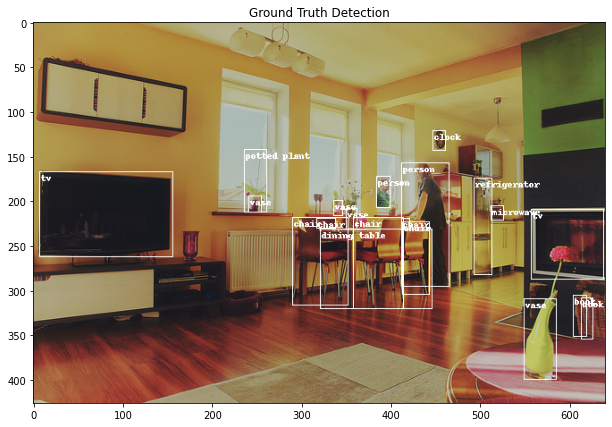

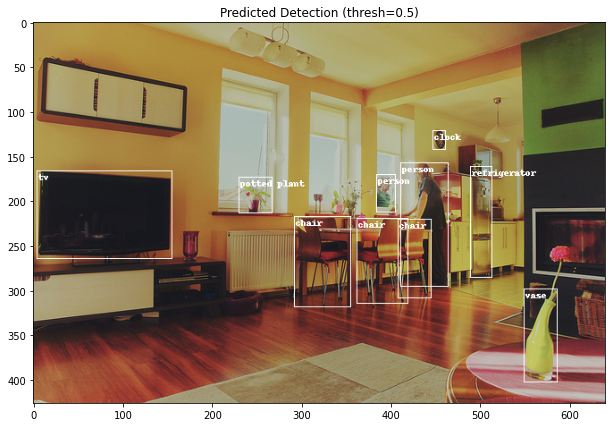

In [ ]:
# Parameters
img_id = 139
th = 0.5  # threshold for confidence score of predicted bboxes to show

# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Get image sample
img = PIL.Image.open(os.path.join(img_dir,dataset.coco.loadImgs([img_id])[0]['file_name']))
img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
img_torchvision = torch.div(img_tensor,255).float().to(device)  # Format image for torchvision models
img_anns = dataset.coco.loadAnns(dataset.coco.getAnnIds([img_id]))

# Generate model predictions
model.eval()
with torch.no_grad():
  if 'YOLO' in model_name:
    pred = model([img])
  else:    
    pred = model([img_torchvision])

# Get label names
label_ids = dataset.coco.getCatIds()
label_info = dataset.coco.loadCats(label_ids)
label_names = [label['name'] for label in label_info]
labels = dict(zip(label_ids,label_names))  # Label dictionary with id-name as key-value
labels_inv = dict(zip(label_names,label_ids))  # Inverse label dictionary with name-id as key-value

# Get ground truth bboxes
true_bboxes = convert_to_xyxy(copy.deepcopy(F.Tensor([obj['bbox'] for obj in img_anns]).to(device)))  # Create deep copy to avoid updating original dataset
true_labels = [labels[obj['category_id']] for obj in img_anns]
true_img = U.draw_bounding_boxes(img_tensor, true_bboxes, true_labels)
plt.figure(figsize = (25,7))
plt.title('Ground Truth Detection')
plot = plt.imshow(F.to_pil_image(true_img))

# Get ground truth segmentation masks
# print(img_anns)
# true_masks = F.Tensor([obj['segmentation'][0] for obj in img_anns])
# true_labels = [labels[obj['category_id']] for obj in img_anns]
# true_img = U.draw_segmentation_masks(img, true_masks, true_labels)
# plt.figure(figsize = (25,7))
# plt.imshow(F.to_pil_image(true_img))

# Get predicted bboxes
# For YOLO models
if 'YOLO' in model_name:  
  pred_bboxes = []
  pred_labels = []
  for img in pred.xyxy:
    for bbox in img:
      if bbox[4] > th:  # Show only bboxes with high confidence score
        pred_bboxes.append(bbox[:4])
        pred_labels.append(labels[labels_inv[label_names[int(bbox[5])]]])  # Convert YOLO label to COCO label
  pred_bboxes = torch.stack(pred_bboxes)
# For torchvision models
else:
  pred_bboxes = torch.stack([pred[0]['boxes'][i] for i in range(0,len(pred[0]['boxes'])) if pred[0]['scores'][i] > th])  # Show only bboxes with high confidence score
  pred_labels_ids = torch.stack([pred[0]['labels'][i] for i in range(0,len(pred[0]['labels'])) if pred[0]['scores'][i] > th]).tolist()
  pred_labels = [labels[label_id] for label_id in pred_labels_ids]
pred_img = U.draw_bounding_boxes(img_tensor, pred_bboxes, pred_labels)
plt.figure(figsize = (25,7))
plt.title(f'Predicted Detection (thresh={th})')
plot = plt.imshow(F.to_pil_image(pred_img))

### Evaluate model on dataset

In [ ]:
# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(f'Model: {model_name}')

# Evaluate model
evaluator, fps, outputs = evaluate(model, data_loader, device)

Model: YOLOv3-tiny
Test:  [  0/625]  eta: 0:07:27  model_time: 0.1938 (0.1938)  evaluator_time: 0.0266 (0.0266)  time: 0.7162  data: 0.3569  max mem: 342
Test:  [100/625]  eta: 0:02:28  model_time: 0.1396 (0.1405)  evaluator_time: 0.0240 (0.0283)  time: 0.2960  data: 0.0187  max mem: 342
Test:  [200/625]  eta: 0:01:58  model_time: 0.1387 (0.1400)  evaluator_time: 0.0258 (0.0266)  time: 0.2761  data: 0.0192  max mem: 342
Test:  [300/625]  eta: 0:01:30  model_time: 0.1391 (0.1400)  evaluator_time: 0.0200 (0.0272)  time: 0.2802  data: 0.0151  max mem: 342
Test:  [400/625]  eta: 0:01:02  model_time: 0.1387 (0.1395)  evaluator_time: 0.0213 (0.0263)  time: 0.2718  data: 0.0168  max mem: 342
Test:  [500/625]  eta: 0:00:34  model_time: 0.1353 (0.1388)  evaluator_time: 0.0199 (0.0257)  time: 0.2605  data: 0.0153  max mem: 342
Test:  [600/625]  eta: 0:00:06  model_time: 0.1377 (0.1384)  evaluator_time: 0.0211 (0.0259)  time: 0.2676  data: 0.0160  max mem: 342
Test:  [624/625]  eta: 0:00:00  mode

ValueError: ignored

### (Optional) Save output results

In [ ]:
# Format to COCO output json 
# out_results = []
# for i, img_id in enumerate(img_ids):  # For every image
#   img_predictions = outputs[i]
#   pred_boxes = img_predictions['boxes'].tolist()
#   pred_labels = img_predictions['labels'].tolist()
#   pred_scores = img_predictions['scores'].tolist()
#   for j in range(0,len(pred_box)):  # For every predicted object
#     pred_box = pred_boxes[j]
#     out_results.append({
#         'image_id': img_id,
#         'category_id': pred_labels[j],
#         'bbox': [round(val,1) for val in pred_box],  # Round for lower file size
#         'score': pred_scores[j]
#         })

# # Save file
# results_dir = '/content'
# out_results_file = f'coco17_{model_id}_outputs.json'
# out_results_path = os.path.join(results_dir, out_results_file)
# with open(out_results_file, 'w') as outfile: 
#     json.dump(out_results, outfile, indent = 2)

### Save metric results

In [ ]:
cols = ['model', 'model_params', 'model_gflops', 'fps', 'max_mem', 'iou_type', 'metric', 'iou', 'area', 'max_dets', 'score']
model = []
model_params_arr = []
model_gflops_arr = []
fps_arr = []
iou_type = []
metric = []
iou = []
area = []
max_dets = []
score = []

# Set column values
for curr_iou_type, coco_eval in evaluator.coco_eval.items():
  model += [model_name for i in range(0,12)]
  model_params_arr += [model_params for i in range(0,12)]
  model_gflops_arr += [model_gflops for i in range(0,12)]
  fps_arr += [fps for i in range(0,12)]
  iou_type += [curr_iou_type for i in range(0,12)]
  metric += ['avg_precision' for i in range(0,6)] + ['avg_recall' for i in range(0,6)]
  iou += ['0.50:0.95', '0.50', '0.75'] + ['0.50:0.95' for i in range(0,9)]
  area += ['all' for i in range(0,3)] + ['small', 'medium', 'large'] + ['all' for i in range(0,3)] + ['small', 'medium', 'large'] 
  max_dets += [100 for i in range(0,6)] + [1, 10] + [100 for i in range(0,4)]
  score += list(coco_eval.stats)

metric_results = pd.DataFrame(np.column_stack([model, model_params_arr, model_gflops_arr, fps_arr, iou_type, metric, iou, area, max_dets, score]))
metric_results.columns = cols

# Safe file
results_dir = '/content'
metric_results_file = f'coco17_{model_id}_metrics.csv'
metric_results_path = os.path.join(results_dir, metric_results_file)
if os.path.exists(metric_results_path):
      os.remove(metric_results_path)
with open(metric_results_path, 'w') as outfile: 
    results.to_csv(outfile)

### Save results to GDrive

In [ ]:
# Mount folder
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Save to GDrive
gdrive_results_dir = '/content/drive/MyDrive/object-detection-results/coco2017'
gdrive_metric_results_path = os.path.join(gdrive_results_dir, metric_results_file)
if os.path.exists(gdrive_metric_results_path):
      os.remove(gdrive_metric_results_path)
with open(gdrive_metric_results_path, 'w') as outfile: 
    metric_results.to_csv(outfile)